# Visual impacts

In [1]:
# ─── Part 1: Calculate Monte Carlo view impacts ───

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from shapely.geometry import Point

# 0) USER PATHS
xlsx       = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"
states_js  = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Census Geo Data/US.json"
ls_dir     = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/ORNL LandScan/landscan-usa-2021-day"
conus_tif  = os.path.join(ls_dir, "landscan-usa-2021-conus-day.tif")

# 1) VIEWSHED BUFFERS & PROJECT SIZES
buffers_m = {
    "Imports QC":    17 * 1609.34,
    "Imports NYISO": 17 * 1609.34,
    "Offshore Wind": 25 * 1609.34,
    "Solar":          3 * 1609.34,
}
proj_size = {
    "Imports QC":    1200,
    "Imports NYISO": 1200,
    "Offshore Wind": 1000,
    "Solar":          100,
}

# 2) MONTE CARLO SETTINGS
n_mc = 10

# 3) BUILD ΔCAPACITY
sheets = pd.read_excel(xlsx, sheet_name=None)
df_list = []
for name, df in sheets.items():
    tmp = df.copy()
    tmp["Pathway"] = name
    df_list.append(tmp)
decarb = pd.concat(df_list, ignore_index=True)

# manual Canadian Hydro for B3
b3_map = {2025: 0, 2050: 3692.308}
decarb["Canadian Hydro"] = 0.0
mask    = decarb["Pathway"]=="B3"
decarb.loc[mask,"Canadian Hydro"] = decarb.loc[mask,"Year"].map(b3_map).fillna(0)

techs_all = ["Solar","Onshore Wind","Offshore Wind",
             "Imports QC","Imports NYISO","Canadian Hydro","SMR","New NG"]
yr0 = decarb["Year"].min()
yr1 = decarb["Year"].max()
df0 = decarb.query("Year==@yr0").set_index("Pathway")
df1 = decarb.query("Year==@yr1").set_index("Pathway")
cap_diff_all = df1[techs_all] - df0[techs_all]

cap_diff = pd.DataFrame({
    "Imports QC":    cap_diff_all["Imports QC"],
    "Imports NYISO": cap_diff_all["Imports NYISO"],
    "Offshore Wind": cap_diff_all["Offshore Wind"],
    "Solar":         cap_diff_all["Solar"]
})
cap_diff = cap_diff.drop(index="A", errors="ignore")
pathways = cap_diff.index.tolist()

# 4) LOAD & PREPARE REGIONS
states = gpd.read_file(states_js).to_crs(epsg=5070)
ne     = states[states["id"].isin(['09','23','25','33','44','50'])]
ne_poly= ne.unary_union
qc     = states[states["id"].isin(['23','33','50'])].unary_union
nyiso  = states[states["id"].isin(['09','25','50'])].unary_union
ow     = states[states["id"].isin(['23','25','44'])]
region_offshore = ow.unary_union.buffer(buffers_m["Offshore Wind"]).difference(ne_poly)

# 5) OPEN LANDSCAN TILE
src = rasterio.open(conus_tif)

# 6) MONTE CARLO EXPOSURE
techs = ["Imports QC","Imports NYISO","Offshore Wind","Solar"]
mc    = np.zeros((n_mc, len(pathways), len(techs)))

for s in range(n_mc):
    for i, pw in enumerate(pathways):
        for j, tech in enumerate(techs):
            delta = cap_diff.at[pw, tech]
            pop_sum = 0.0
            if delta>0:
                n_proj = int(np.ceil(delta / proj_size[tech]))
                region = {
                  "Imports QC": qc,
                  "Imports NYISO": nyiso,
                  "Offshore Wind": region_offshore
                }.get(tech, ne_poly)

                # sprinkle random points
                pts = []
                minx, miny, maxx, maxy = region.bounds
                while len(pts)<n_proj:
                    x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
                    p = Point(x, y)
                    if region.contains(p):
                        pts.append(p)

                # buffer & mask population
                for p in pts:
                    buf   = p.buffer(buffers_m[tech])
                    geoms = gpd.GeoSeries([buf], crs=states.crs).to_crs(src.crs).geometry
                    arr, _ = rasterio.mask.mask(src, geoms, crop=True, nodata=0)
                    pop_sum += arr.sum()

            mc[s,i,j] = pop_sum

# convert to million people
mc /= 1e6


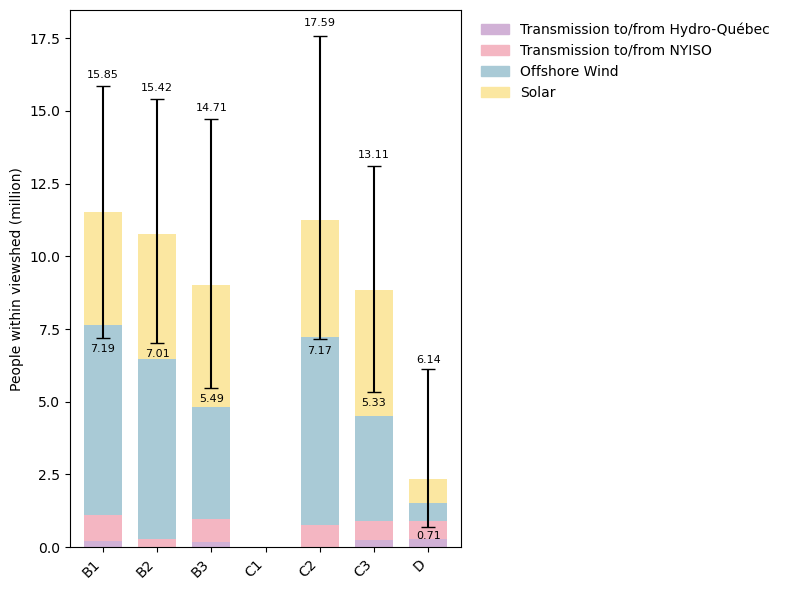

In [2]:
# ─── Part 2: Plot with 10/90% CI & build Excel table ───

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) compute mean & 10/90th‐percentile per tech & total
mean_vals = mc.mean(axis=0)
low_vals  = np.percentile(mc, 5, axis=0)
high_vals = np.percentile(mc, 95, axis=0)

mean_df = pd.DataFrame(mean_vals, index=pathways, columns=techs)
low_df  = pd.DataFrame(low_vals,  index=pathways, columns=techs)
high_df = pd.DataFrame(high_vals, index=pathways, columns=techs)

# totals per pathway
mean_total = mean_df.sum(axis=1)
low_total  = low_df.sum(axis=1)
high_total = high_df.sum(axis=1)

# 2) plot stacked bars + 10/90% CI error bars
colors = {
    "Solar":         "#FBE7A1",
    "Imports QC":    "#D1B1D6",
    "Imports NYISO": "#F4B6C2",
    "Offshore Wind": "#A9CAD6"
}
legend_map = {
    "Solar":         "Solar",
    "Imports QC":    "Transmission to/from Hydro-Québec",
    "Imports NYISO": "Transmission to/from NYISO",
    "Offshore Wind": "Offshore Wind"
}

ax = mean_df.plot(
    kind='bar', stacked=True,
    color=[colors[t] for t in techs],
    figsize=(8,6), width=0.7
)
ax.set_xticklabels(pathways, rotation=45, ha='right')
ax.set_ylabel("People within viewshed (million)")

# prepare non‐negative CI errors
err_low_vals  = (mean_total - low_total).abs().values
err_high_vals = (high_total - mean_total).abs().values
yerr          = np.vstack([err_low_vals, err_high_vals])

mask = np.array(pathways) != "C1"
x    = np.arange(len(pathways))
x_err       = x[mask]
mean_err    = mean_total.values[mask]
yerr_masked = yerr[:, mask]

ax.errorbar(
    x_err, mean_err,
    yerr=yerr_masked,
    fmt='none', ecolor='black', capsize=5
)

# annotate 10th & 90th bounds
for idx in np.where(mask)[0]:
    xi = x[idx]
    lo = low_total.values[idx]
    hi = high_total.values[idx]
    span = hi - lo
    off  = span * 0.025
    ax.text(xi, hi + off, f"{hi:.2f}", ha='center', va='bottom', fontsize=8)
    ax.text(xi, lo - off, f"{lo:.2f}", ha='center', va='top',    fontsize=8)

# legend
handles = [plt.matplotlib.patches.Patch(color=colors[t], label=legend_map[t])
           for t in techs]
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02,1), frameon=False)

plt.tight_layout()
plt.savefig('visual_impacts.png', dpi=300,
            bbox_inches='tight', pad_inches=0.1)
plt.show()


# 3) build & save Excel table: mean (10–90% CI)
rows = techs + ['Sum']
table = pd.DataFrame(index=rows, columns=pathways, dtype=object)

# fill tech rows
for tech in techs:
    for pw in pathways:
        m  = mean_df.at[pw, tech]
        lo = low_df.at[pw, tech]
        hi = high_df.at[pw, tech]
        table.at[tech, pw] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# fill Sum row
for pw in pathways:
    m  = mean_total.at[pw]
    lo = low_total.at[pw]
    hi = high_total.at[pw]
    table.at['Sum', pw] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# pretty‐print index & add units
rename_map = {
    "Solar":         "Solar",
    "Offshore Wind": "Off‐shore wind",
    "Imports QC":    "Transmission to/from Hydro-Québec",
    "Imports NYISO": "Transmission to/from NYISO"
}
table = table.rename(index=rename_map)
table.index.name = 'Technology'
table.insert(0, 'Unit', ['People within viewshed (million)'] * len(table))

# save to Excel
table.to_excel(
    'viewshed_summary.xlsx',
    sheet_name='Viewshed population',
    startrow=1
)